In [ ]:
# !pip install iplantuml

## Impotação de bibliotecas 

In [6]:
import iplantuml

## Configuração de serviços - CanalSeguro 

### 1. Linked Service 

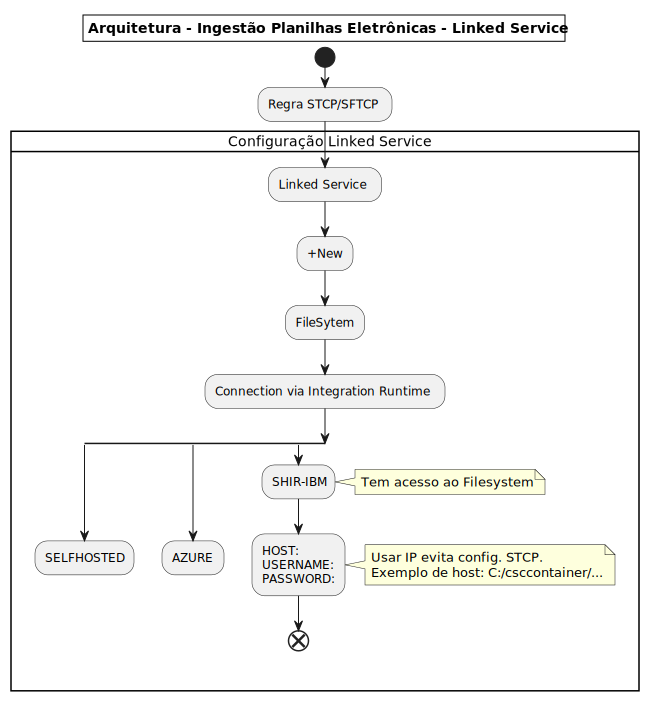

In [55]:
%%plantuml --jar

@startuml 

title Arquitetura - Ingestão Planilhas Eletrônicas - Linked Service
start
:Regra STCP/SFTCP;
card "Configuração Linked Service" { 

:Linked Service ; 
:+New;
:FileSytem;
:Connection via Integration Runtime;
split

:SELFHOSTED;

kill
split again
:AZURE;
detach
split again
:SHIR-IBM;
note right
Tem acesso ao Filesystem
end note
:HOST:
USERNAME:
PASSWORD:;
note right
Usar IP evita config. STCP. 
Exemplo de host: C:/csccontainer/...
end note
end
end split

}

@enduml 

### 2. Dataset

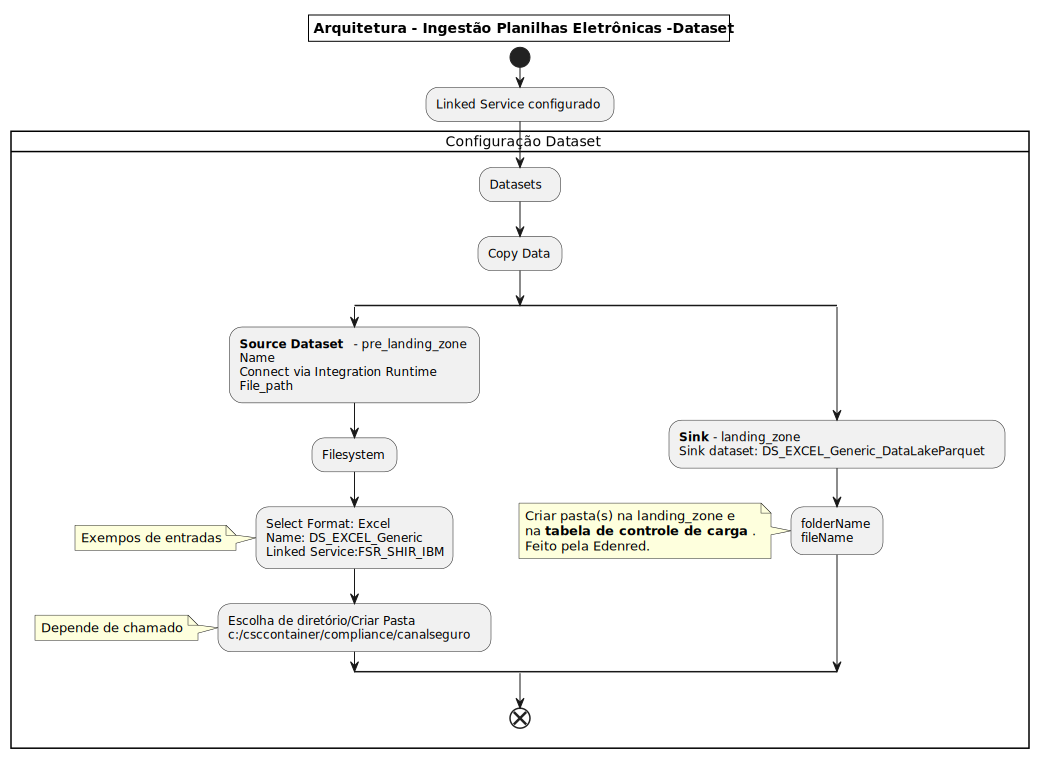

In [11]:
%%plantuml --jar

@startuml

title Arquitetura - Ingestão Planilhas Eletrônicas - Dataset
start
:Linked Service configurado;
card "Configuração Dataset" { 
:Datasets ; 
:Copy Data;
split
:**Source Dataset** - pre_landing_zone
Name
Connect via Integration Runtime
File_path;
:Filesystem;
:Select Format: Excel
Name: DS_EXCEL_Generic
Linked Service:FSR_SHIR_IBM;
note left
Exempos de entradas
end note
:Escolha de diretório/Criar Pasta
c:/csccontainer/compliance/canalseguro;
note left
Depende de chamado
end note
split again
:**Sink** - landing_zone
Sink dataset: DS_EXCEL_Generic_DataLakeParquet;
:folderName 
fileName;
note left 
Criar pasta(s) na landing_zone e 
na **tabela de controle de carga**.
Feito pela Edenred.
end note
end split
end
}

@enduml 

### 3. Pipeline

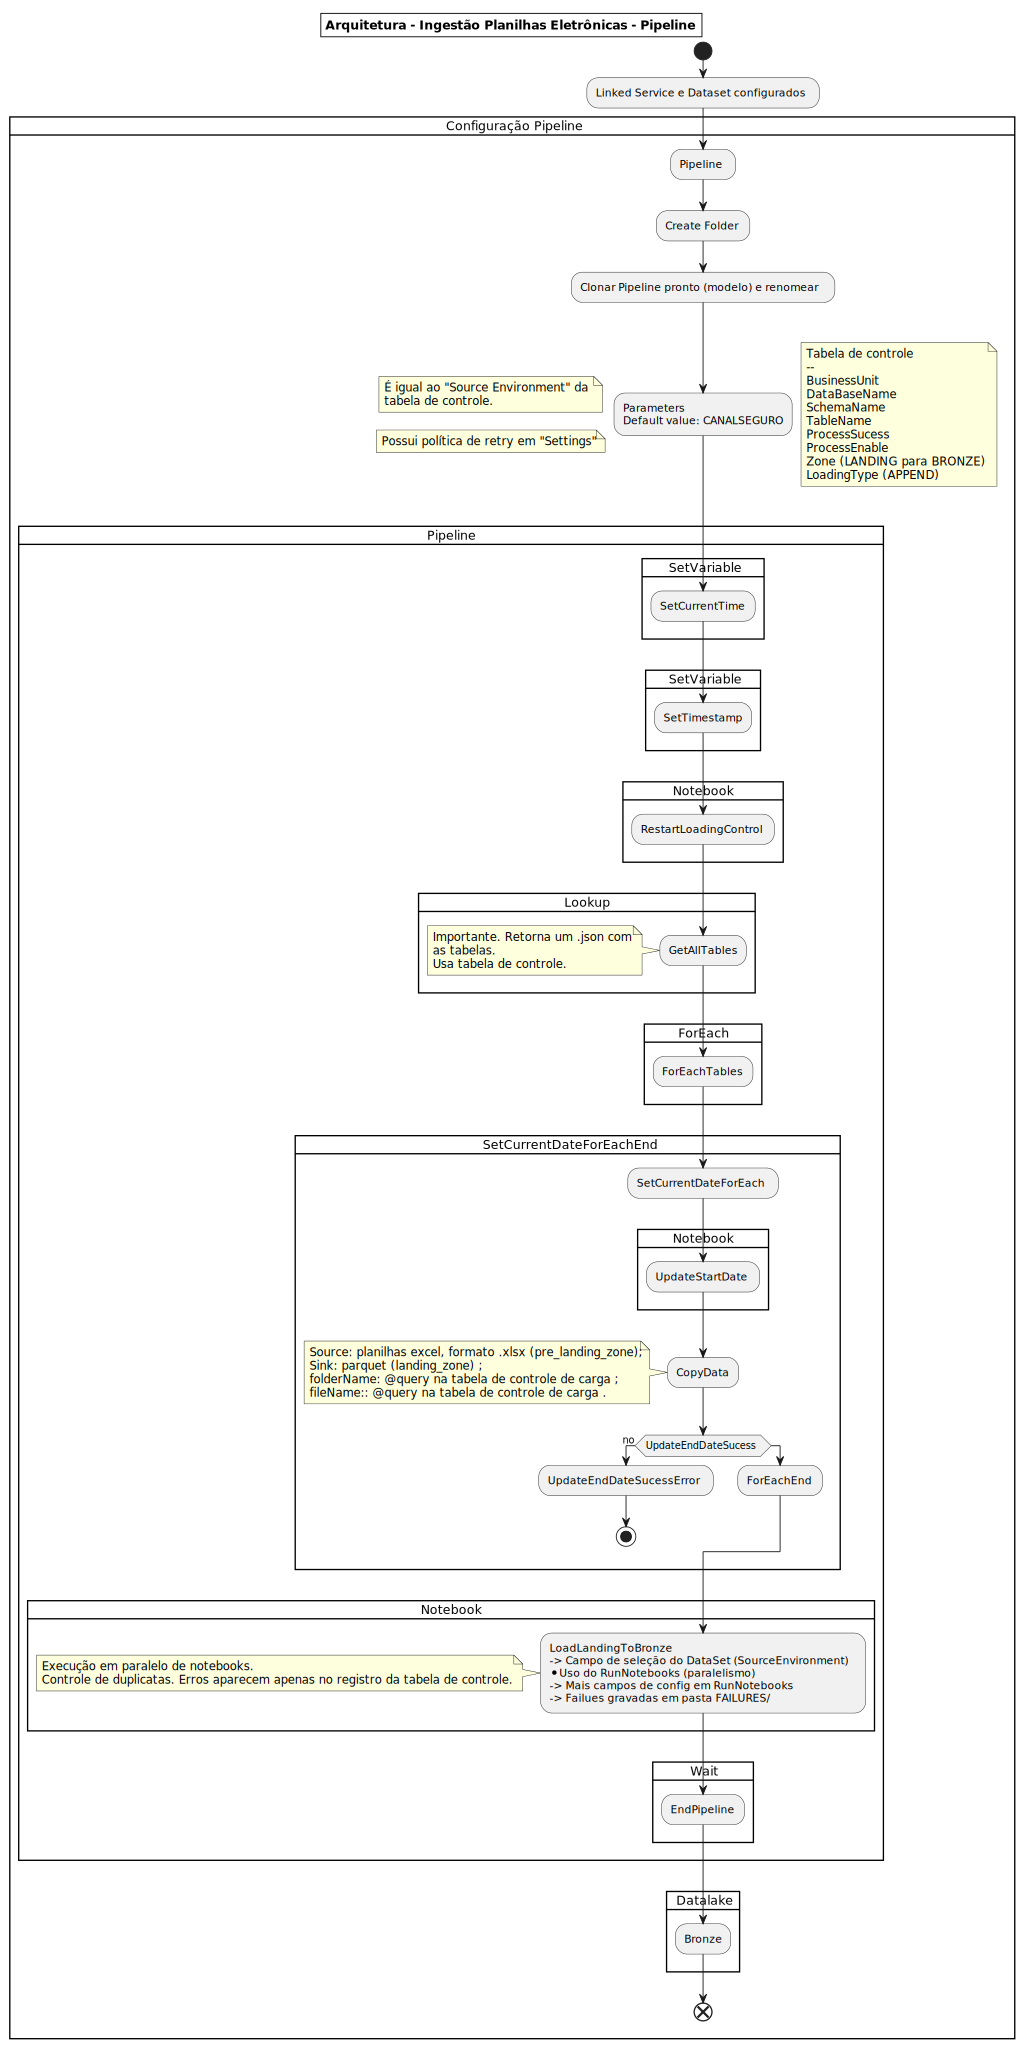

In [13]:
%%plantuml --jar 

@startuml

title Arquitetura - Ingestão Planilhas Eletrônicas - Pipeline
start
:Linked Service e Dataset configurados;
card "Configuração Pipeline" { 
:Pipeline ; 
:Create Folder;
:Clonar Pipeline pronto (modelo) e renomear;
:Parameters
Default value: CANALSEGURO;
note left
É igual ao "Source Environment" da 
tabela de controle.
end note

note right
Tabela de controle
--
BusinessUnit 
DataBaseName
SchemaName
TableName
ProcessSucess
ProcessEnable
Zone (LANDING para BRONZE)
LoadingType (APPEND)
end note
note left
Possui política de retry em "Settings"
end note

card "Pipeline" { 
    card "SetVariable"  {
:SetCurrentTime;
}

card  "SetVariable"  {
:SetTimestamp;
}
card  "Notebook"  {
:RestartLoadingControl;
}
card  "Lookup"  {
:GetAllTables;
}
note 
Importante. Retorna um .json com
as tabelas. 
Usa tabela de controle.
end note

card  "ForEach"  {
:ForEachTables;
} 
card SetCurrentDateForEachEnd {

:SetCurrentDateForEach;

card "Notebook"{
    :UpdateStartDate;
}

:CopyData;
note 
Source: planilhas excel, formato .xlsx (pre_landing_zone);
Sink: parquet (landing_zone) ; 
folderName: @query na tabela de controle de carga ; 
fileName:: @query na tabela de controle de carga .
end note

if (UpdateEndDateSucess) then (no)
:UpdateEndDateSucessError;
stop
else ()
:ForEachEnd;

endif
} 
card  "Notebook"  {
:LoadLandingToBronze
-> Campo de seleção do DataSet (SourceEnvironment)
* Uso do RunNotebooks (paralelismo)
-> Mais campos de config em RunNotebooks
-> Failues gravadas em pasta FAILURES/;
note left 
Execução em paralelo de notebooks.
Controle de duplicatas. Erros aparecem apenas no registro da tabela de controle. 
end note
}
card  "Wait"  {
:EndPipeline;
}
}
card "Datalake" {
    :Bronze;
}

end
@enduml 

## Visão Geral das Capturas de Dados : 

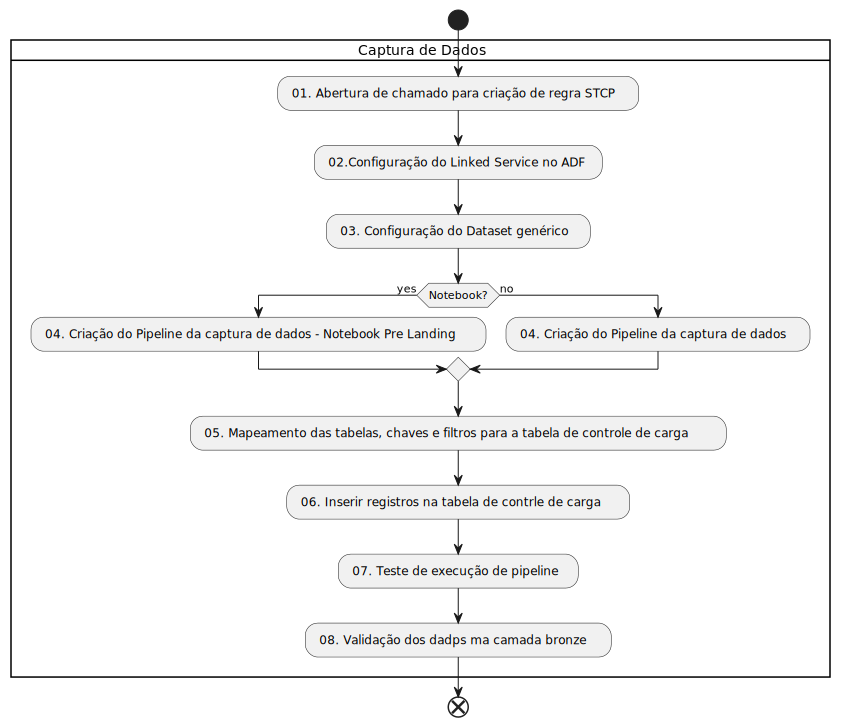

In [15]:
%%plantuml --jar

@startuml 

start 

card "Captura de Dados" {
: 01. Abertura de chamado para criação de regra STCP;
: 02.Configuração do Linked Service no ADF;
: 03. Configuração do Dataset genérico;
if (Notebook?) then (yes)
: 04. Criação do Pipeline da captura de dados - Notebook Pre Landing;
else (no)
: 04. Criação do Pipeline da captura de dados;
endif
: 05. Mapeamento das tabelas, chaves e filtros para a tabela de controle de carga;
: 06. Inserir registros na tabela de contrle de carga ;
: 07. Teste de execução de pipeline;
: 08. Validação dos dadps ma camada bronze ;
}
end

@enduml 

### 1. JIRA 

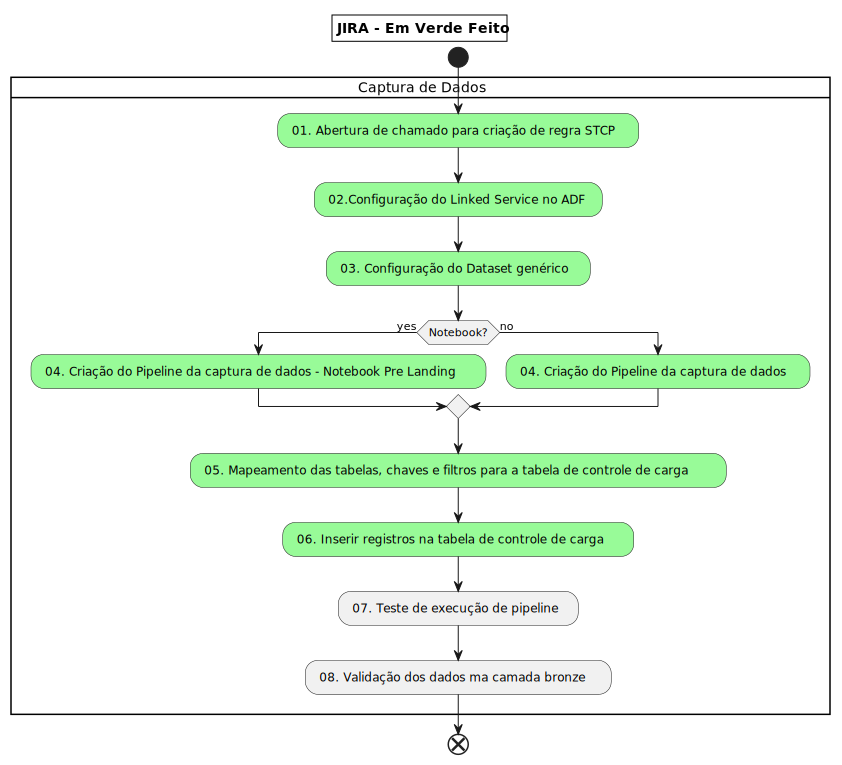

In [16]:
%%plantuml --jar

@startuml 

title JIRA - Em Verde Feito
start 

card "Captura de Dados" {
#palegreen: 01. Abertura de chamado para criação de regra STCP;
#palegreen: 02.Configuração do Linked Service no ADF;
#palegreen: 03. Configuração do Dataset genérico;
if (Notebook?) then (yes)
#palegreen: 04. Criação do Pipeline da captura de dados - Notebook Pre Landing;
else (no)
#palegreen: 04. Criação do Pipeline da captura de dados;
endif
#palegreen: 05. Mapeamento das tabelas, chaves e filtros para a tabela de controle de carga;
#palegreen: 06. Inserir registros na tabela de controle de carga ;
: 07. Teste de execução de pipeline;
: 08. Validação dos dados ma camada bronze ;
}
end

@enduml 

### 2. ZURI

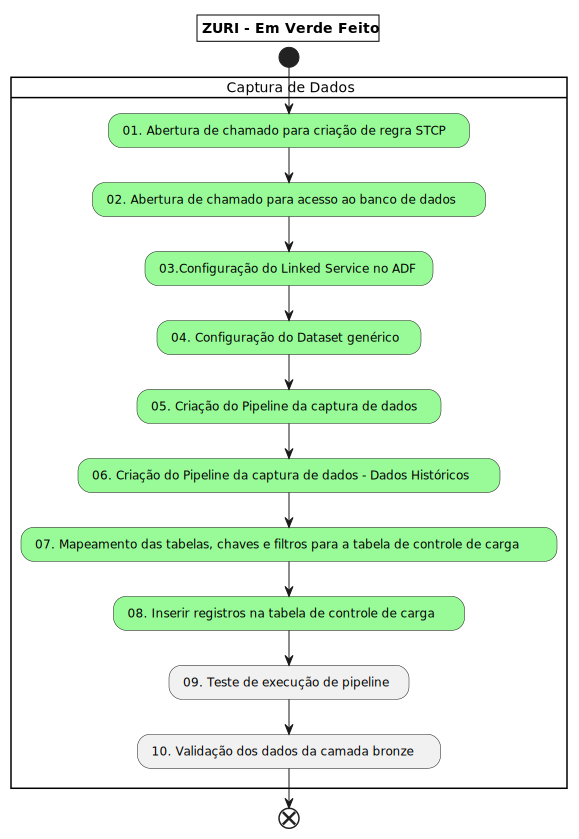

In [17]:
%%plantuml --jar

@startuml 

title ZURI - Em Verde Feito
start 

card "Captura de Dados" {
#palegreen: 01. Abertura de chamado para criação de regra STCP;
#palegreen: 02. Abertura de chamado para acesso ao banco de dados;
#palegreen: 03.Configuração do Linked Service no ADF;
#palegreen: 04. Configuração do Dataset genérico;
#palegreen: 05. Criação do Pipeline da captura de dados;
#palegreen: 06. Criação do Pipeline da captura de dados - Dados Históricos;
#palegreen: 07. Mapeamento das tabelas, chaves e filtros para a tabela de controle de carga;
#palegreen: 08. Inserir registros na tabela de controle de carga ;
: 09. Teste de execução de pipeline;
: 10. Validação dos dados da camada bronze ;
}
end

@enduml 

### 3. ELAW

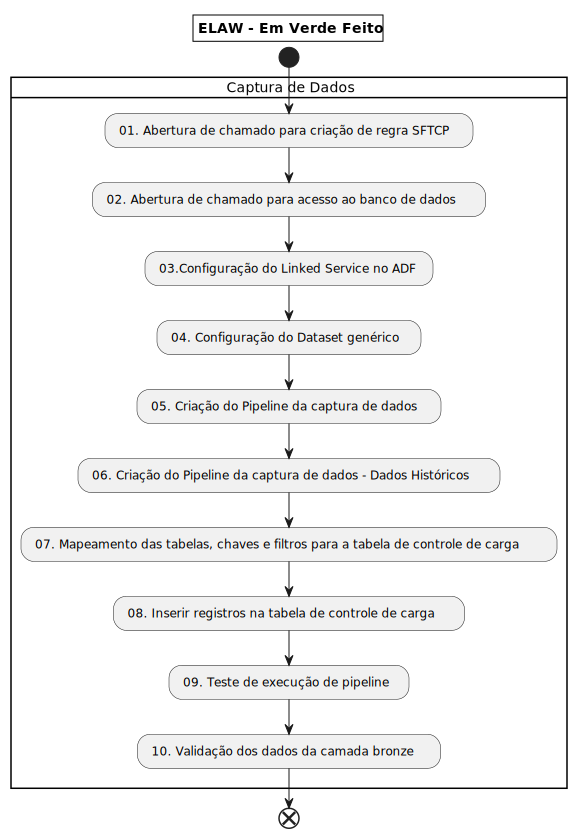

In [18]:
%%plantuml --jar 

@startuml 

title ELAW - Em Verde Feito
start 

card "Captura de Dados" {
: 01. Abertura de chamado para criação de regra SFTCP;
: 02. Abertura de chamado para acesso ao banco de dados;
: 03.Configuração do Linked Service no ADF;
: 04. Configuração do Dataset genérico;
: 05. Criação do Pipeline da captura de dados;
: 06. Criação do Pipeline da captura de dados - Dados Históricos;
: 07. Mapeamento das tabelas, chaves e filtros para a tabela de controle de carga;
: 08. Inserir registros na tabela de controle de carga ;
: 09. Teste de execução de pipeline;
: 10. Validação dos dados da camada bronze ;
}
end

@enduml 